<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Single-cell-virus-sequencing" data-toc-modified-id="Single-cell-virus-sequencing-1">Single-cell virus sequencing</a></span><ul class="toc-item"><li><span><a href="#Set-up-for-analysis" data-toc-modified-id="Set-up-for-analysis-1.1">Set up for analysis</a></span></li><li><span><a href="#Target-amplicons" data-toc-modified-id="Target-amplicons-1.2">Target amplicons</a></span></li></ul></li></ul></div>

# Single-cell virus sequencing
This example shows how to use `alignparse` to process full-length PacBio CCSs of viral cDNAs generated in single-cell virus sequencing of influenza-infected cells.
Specifically, it processes a snippet of data taking from [Russell et al, 2019](https://jvi.asm.org/content/93/14/e00500-19), which was generatetd by PacBio sequencing of viral cDNAs with UMIS and cell barcodes added using a 10X Chromium (v2 reagents).
This notebook aligns these CCSs to the influenza transcripts and parses the barcodes / UMIs and viral mutations.

## Set up for analysis
Import necessary Python modules.
We use `alignparse` for most of the operations, [plotnine](https://plotnine.readthedocs.io) for ggplot2-like plotting, and a few functitons from [dms_variants](https://jbloomlab.github.io/dms_variants):

In [1]:
import os
import warnings

import numpy

import pandas as pd

from plotnine import *

import alignparse.ccs
import alignparse.consensus
import alignparse.minimap2
import alignparse.targets
from alignparse.constants import CBPALETTE

import dms_variants.plotnine_themes
import dms_variants.utils

Suppress warnings that clutter output:

In [2]:
warnings.simplefilter('ignore')

Set [plotnine](https://plotnine.readthedocs.io/en/stable/) theme to the one defined in [dms_variants](https://jbloomlab.github.io/dms_variants):

In [3]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

Directory for output:

In [4]:
outdir = './output_files/'
os.makedirs(outdir, exist_ok=True)

## Target amplicons
The alignment targets consist of PCR ampliconsing the influenza virus mRNAs (WSN strain) with a 5' termini corresponding to the primer binding site, the 3' polyA tail used for reverse transcription, the UMI and cell barcode, and the common 3' termini.
There are also variant tags distinguishing the synonymously tagged viral variants (see [Russell et al, 2019](https://jvi.asm.org/content/93/14/e00500-19)).

First, let's look at the Genbank file holding the targets.
Below we show the first 25 lines (the actual file is quite large as it defined all 10 influenza mRNAs):

In [5]:
targetfile = 'input_files/flu_WSN_amplicons.gb'

nlines_to_show = 25
with open(targetfile) as f:
    print(''.join(next(f) for _ in range(nlines_to_show)))

LOCUS       fluPB2                  2397 bp    DNA              UNK 01-JAN-1980
DEFINITION  fluPB2.
ACCESSION   fluPB2
VERSION     fluPB2
KEYWORDS    .
SOURCE      .
  ORGANISM  .
            .
FEATURES             Location/Qualifiers
     termini5        1..34
     variant_tag_1   142..142
     variant_tag_2   148..148
     variant_tag_3   2162..2162
     variant_tag_4   2170..2170
     sequenced_mRNA  35..2319
     polyA           2320..2349
     UMI             2350..2359
     cell_barcode    2360..2375
     termini3        2376..2397
ORIGIN
        1 gcgaaagcag gtcaattata ttcaatatgg aaagaataaa agaactaagg aatctaatgt
       61 cgcagtctcg cactcgcgag atactcacaa aaaccaccgt ggaccatatg gccataatca
      121 agaagtacac atcaggaaga cargagaara acccagcact taggatgaaa tggatgatgg
      181 caatgaaata tccaattaca gcagacaaga ggataacgga aatgattcct gagagaaatg
      241 agcagggaca aactttatgg agtaaaatga atgacgccgg atcagaccga gtgatggtat



We also have the YAML file specifying how to parse the features in the alignments.
Note how this file uses the YAML syntax for defaults to avoid repeating the same specifications for each target:

In [6]:
feature_parse_specs_file = 'input_files/flu_WSN_feature_parse_specs.yaml'
with open(feature_parse_specs_file) as f:
    print(f.read())

# default for genes with two variant tags
default_2tags: &default_2tags
  query_clip5: 4
  query_clip3: 4
  termini5:
    filter:
      clip5: 4
      mutation_nt_count: 1
      mutation_op_count: null
  sequenced_mRNA:
    filter:
      mutation_nt_count: null
      mutation_op_count: 10
    return: [sequence, accuracy]
  polyA:
    filter:
      mutation_nt_count: 10
      mutation_op_count: 3
  UMI:
    return: [sequence, accuracy]
  cell_barcode:
    return: [sequence, accuracy]
  termini3:
    filter:
      clip5: 4
      mutation_nt_count: 1
      mutation_op_count: null
  variant_tag_1:
    return: sequence
  variant_tag_2:
    return: sequence

# default for genes with four variant tags
default_4tags: &default_4tags
  <<: *default_2tags
  variant_tag_3:
    return: sequence
  variant_tag_4:
    return: sequence

# use defaults to define specs for actual genes
fluPB2:
  <<: *default_4tags

fluPB1:
  <<: *default_4tags

fluPA:
  <<: *default_4tags

fluHA:
  <<: *default_4tags

fl

We now read the targets into an `alignparse.targets.Targets` object with the feature-parsing specs (ignoring the keys that define thet defaults):

In [7]:
targets = alignparse.targets.Targets(
                seqsfile=targetfile,
                feature_parse_specs=feature_parse_specs_file,
                ignore_feature_parse_specs_keys=['default_2tags',
                                                 'default_4tags'])

Plot the `Targets`:

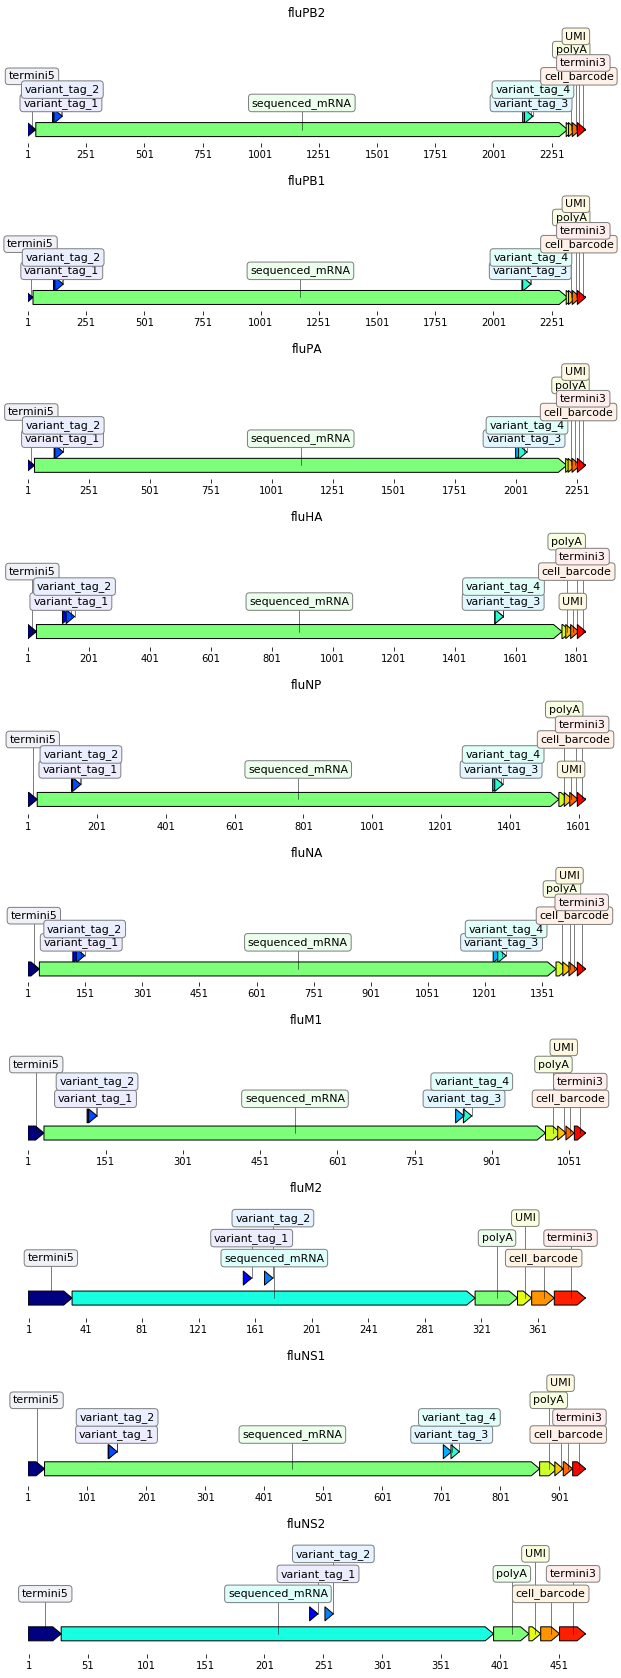

In [8]:
_ = targets.plot(ax_width=10)